# Project: Food Vision

## Check GPU

Google Colab offers free GPUs (thank you Google), however, not all of them are compatiable with mixed precision training.

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible) 
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to a Tesla T4 (from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+ (see here: https://developer.nvidia.com/cuda-gpus).

📖 **Resource:** You can read more about the benefits of mixed precision training in the TensorFlow Mixed Precision documentation: https://www.tensorflow.org/guide/mixed_precision 


In [1]:
# If the following line doesn't output "Tesla T4", you can try getting access to
# another GPU by going to Runtime -> Factory Reset Runtime -> "Yes" and then
# re-running this cell.
!nvidia-smi -L

GPU 0: NVIDIA GeForce MX330 (UUID: GPU-77eebd61-350b-2f9c-b351-0acab8f44c51)


**NOTE:** Since I don't have a good GPU for mixed precision, I had executed the code in Google Colab using the Tesla T4 GPU and had paste the output here.

## Get helper functions
helper.py file consists of many pre-written functions such as for graphs etc. which will be very useful in this project.


In [4]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

If you want to get an overview of TensorFlow Datasets (TFDS), read the guide: https://www.tensorflow.org/datasets/overview

In [6]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

**IMPORTANT NOTE:** Some of the datasets contained within TensorFlow datasets are over 100GB+, meaning if you run the cell below (outside of Google Colab), you might be downloading 100GB+ to your computer or the computer that you're using. Beware as this could take a large amount of bandwidth.

In [7]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target dataset in the list of TFDS datasets?

True


In [ ]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"], # splits can be a little tricky, for more see: https://www.tensorflow.org/datasets/splits 
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True) # for meta-data

#OUTPUT:
# Downloading and preparing dataset 4.65 GiB (download: 4.65 GiB, generated: Unknown size, total: 4.65 GiB) to /root/tensorflow_datasets/food101/2.0.0...
# Dl Completed...: 100%
# 1/1 [11:00<00:00, 343.23s/ url]
# Dl Size...: 100%
# 4764/4764 [11:00<00:00, 15.26 MiB/s]
# Extraction completed...: 94%
# 101008/101008 [11:00<00:00, 1083.67 file/s]
# Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.

## Exploring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [ ]:
# Features of Food101 from TFDS
ds_info.features

#OUTPUT:
# FeaturesDict({
#     'image': Image(shape=(None, None, 3), dtype=uint8),
#     'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
# })

In [ ]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

# OUTPUT:
# ['apple_pie',
#  'baby_back_ribs',
#  'baklava',
#  'beef_carpaccio',
#  'beef_tartare',
#  'beet_salad',
#  'beignets',
#  'bibimbap',
#  'bread_pudding',
#  'breakfast_burrito']


In [ ]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [ ]:
# What does one sample of our training data look like?
train_one_sample

# OUTPUT:
# <_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)

  # OUTPUT:
  # Image shape: (512, 512, 3)
  # Image datatype: <dtype: 'uint8'>
  # Target class from Food101 (tensor form): 72
  # Class name (str form): pancakes

In [ ]:
# What does our image tensor from TFDS's Food101 look like?
image

#OUTPUT:
# <tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
# array([[[ 42,  40,  51],
#         [ 41,  39,  50],
#         [ 40,  38,  49],
#         ...,
#         [ 50,  23,   6],
#         [ 51,  24,   7],
#         [ 51,  24,   7]],

#        [[ 41,  39,  50],
#         [ 41,  39,  50],
#         [ 41,  39,  50],
#         ...,
#         [ 47,  20,   3],
#         [ 48,  21,   4],
#         [ 49,  22,   5]],

#        [[ 40,  38,  49],
#         [ 41,  39,  50],
#         [ 42,  40,  51],
#         ...,
#         [ 47,  20,   3],
#         [ 48,  21,   4],
#         [ 48,  21,   4]],

#        ...,

#        [[188, 180, 191],
#         [188, 180, 191],
#         [189, 181, 192],
#         ...,
#         [179, 178, 186],
#         [177, 176, 184],
#         [175, 174, 182]],

#        [[185, 177, 188],
#         [186, 178, 189],
#         [187, 179, 190],
#         ...,
#         [178, 177, 185],
#         [176, 175, 183],
#         [175, 174, 182]],

#        [[179, 171, 182],
#         [181, 173, 184],
#         [183, 175, 186],
#         ...,
#         [177, 176, 184],
#         [176, 175, 183],
#         [174, 173, 181]]], dtype=uint8)>


In [ ]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

# OUTPUT:
# (<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
#  <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Datasets

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is assosciated with the right image
plt.axis(False);

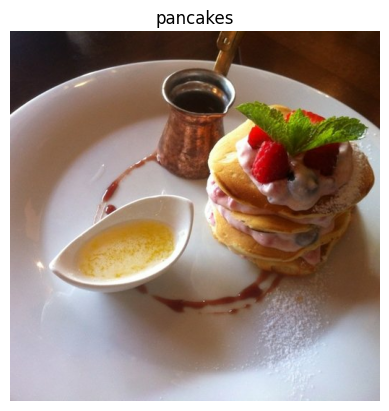

## Create preprocessing functions for our data

Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc).

However, not all data (including data from from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensors generally perform better

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretrained model from tf.keras.applications we don't need to rescale our data (these architectures have rescaling built-in).

This means our functions needs to:
1. Reshape our images to all the same size
2. Convert the dtype of our image tensors from `unit8` to `float32`

In [ ]:
# Our data comes in the tuple structure: (image, label)

In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes
  image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  # image = image/255. # scale image values (not required with EfficientNetBX models from tf.keras.applications)
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n{preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

# OUTPUT:
# Image before preprocessing:
#  [[[42 40 51]
#   [41 39 50]
#   [40 38 49]
#   ...
#   [50 23  6]
#   [51 24  7]
#   [51 24  7]]

#  [[41 39 50]
#   [41 39 50]
#   [41 39 50]
#   ...
#   [47 20  3]
#   [48 21  4]
#   [49 22  5]]]..., 
# Shape: (512, 512, 3),
# Datatype: <dtype: 'uint8'>

# Image after preprocessing:
# [[[41.127552  39.127552  50.127552 ]
#   [40.642857  38.642857  49.642857 ]
#   [40.285713  38.285713  49.285713 ]
#   ...
#   [48.92855   21.928549   4.500022 ]
#   [47.7398    20.7398     3.7398005]
#   [49.301044  22.301043   5.3010426]]

#  [[40.642857  38.642857  49.642857 ]
#   [42.9949    40.9949    51.9949   ]
#   [41.85714   39.85714   50.85714  ]
#   ...
#   [49.127533  22.127531   4.699003 ]
#   [47.862247  20.862246   3.8622465]
#   [48.928574  21.928572   4.9285717]]]...,
# Shape: (224, 224, 3),
# Datatype: <dtype: 'float32'>

## Batch & prepare datasets

We're now going to make our data input pipeline run really fast. 

For more resources: https://www.tensorflow.org/guide/data_performance

In [ ]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

# OUTPUT:
# (<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
#  <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

> **NOTE:** *Performance data pipeline does the following:* Map this preprocessing function (`preprocess_img`) across our training dataset, then shuffle a number of elements and then batch them together and finally make sure that it prepare new batches (prefetch) whilst the model is looking through (finding patterns) in the current batch."

## Create modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard callback to log training results (so we can visualize them later if need be)
* ModelCheckpoint callback to save our model's progress after feature extraction

In [ ]:
# Create tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training 
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0) # don't print whether or not model is being saved

## Setup mixed precision training

Check out the TensorFlow guide for mixed precision: https://www.tensorflow.org/guide/mixed_precision

Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance.

In [9]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

#The below error has occurred because of the incompatible GPU which I have.

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [10]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model doesn't you can have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # makes sure layers which should be in inference mode only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs) 

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


#OUTPUT:
# Downloading data from https://storage.googleapis.com/keras-applications/efficientnetb0_notop.h5
# 16705208/16705208 [==============================] - 2s 0us/step

In [ ]:
model.summary()

#OUTPUT:
# Model: "model"
# _________________________________________________________________
#  Layer (type)                Output Shape              Param #   
# =================================================================
#  input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
#  efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
#  global_average_pooling2d (G  (None, 1280)             0         
#  lobalAveragePooling2D)                                          
                                                                 
#  dense (Dense)               (None, 101)               129381    
                                                                 
#  softmax_float32 (Activation  (None, 101)              0         
#  )                                                               
                                                                 
# =================================================================
# Total params: 4,178,952
# Trainable params: 129,381
# Non-trainable params: 4,049,571
# _________________________________________________________________

## Checking layer dtype policies (are we using mixed precision?)

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

#OUTPUT:
# input_layer True float32 <Policy "float32">
# efficientnetb0 False float32 <Policy "mixed_float16">
# global_average_pooling2d True float32 <Policy "mixed_float16">
# dense True float32 <Policy "mixed_float16">
# softmax_float32 True float32 <Policy "float32">

Going through the above we see:
* `layer.name`: the human readable name of a particular layer
* `layer.trainable`: is the layer trainable or not? (if `False`, the weights are frozen)
* `layer.dtype`: the data type a layer stores its variables in
* `layer.dtype_policy`: the data type policy a layer computes on its variables with

In [ ]:
# Check the dtype_policy attributes of layers in the base model
for layer in model.layers[1].layers[:20]: # check the layers of the base model (layer at index 1 of `model`)
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

#OUTPUT:
# input_1 False float32 <Policy "float32">
# rescaling False float32 <Policy "mixed_float16">
# normalization False float32 <Policy "mixed_float16">
# rescaling_1 False float32 <Policy "mixed_float16">
# stem_conv_pad False float32 <Policy "mixed_float16">
# stem_conv False float32 <Policy "mixed_float16">
# stem_bn False float32 <Policy "mixed_float16">
# stem_activation False float32 <Policy "mixed_float16">
# block1a_dwconv False float32 <Policy "mixed_float16">
# block1a_bn False float32 <Policy "mixed_float16">
# block1a_activation False float32 <Policy "mixed_float16">
# block1a_se_squeeze False float32 <Policy "mixed_float16">
# block1a_se_reshape False float32 <Policy "mixed_float16">
# block1a_se_reduce False float32 <Policy "mixed_float16">
# block1a_se_expand False float32 <Policy "mixed_float16">
# block1a_se_excite False float32 <Policy "mixed_float16">
# block1a_project_conv False float32 <Policy "mixed_float16">
# block1a_project_bn False float32 <Policy "mixed_float16">
# block2a_expand_conv False float32 <Policy "mixed_float16">
# block2a_expand_bn False float32 <Policy "mixed_float16">

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model (train a couple output layers with base layers frozen) 
2. Fine-tune some of the frozen layers

In [ ]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=(len(train_data)),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                            experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

#OUTPUT:
# WARNING:tensorflow:Model failed to serialize as JSON. Ignoring... Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.
# Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230604-180037
# Epoch 1/3
# 2368/2368 [==============================] - 224s 87ms/step - loss: 1.7183 - accuracy: 0.5840 - val_loss: 1.1230 - val_accuracy: 0.6954
# Epoch 2/3
# 2368/2368 [==============================] - 207s 86ms/step - loss: 1.1993 - accuracy: 0.6892 - val_loss: 1.0306 - val_accuracy: 0.7214
# Epoch 3/3
# 2368/2368 [==============================] - 209s 87ms/step - loss: 1.0537 - accuracy: 0.7240 - val_loss: 0.9891 - val_accuracy: 0.7272

In [ ]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

#OUTPUT:
# 790/790 [==============================] - 60s 75ms/step - loss: 0.9956 - accuracy: 0.7283
# [0.9955681562423706, 0.7282772064208984]

## Load and evaluate checkpoint weights:
We can load in and evaluate our model's checkpoints by:

1. Recreating a new instance of our model called created_model by turning our original model creation code into a function called create_model().
2. Compiling our created_model with the same loss, optimizer and metrics as the original model (every time you create a new model, you must compile it).
3. Calling the load_weights() method on our created_model and passing it the path to where our checkpointed weights are stored.
4. Calling evaluate() on created_model with loaded weights and saving the results.
5. Comparing the created_model results to our previous model results (these should be the exact same, if not very close).

> A reminder, checkpoints are helpful for when you perform an experiment such as fine-tuning your model. In the case you fine-tune your feature extraction model and find it doesn't offer any improvements, you can always revert back to the checkpointed version of your model.

**IMPORTANT NOTE:** This section originally used the tf.keras.clone_model method, however, due to several potential errors with that method, it changed to create a new model (rather than cloning) via a create_model() function. See the discussion on the course GitHub for more.

In [ ]:
# 1. Create a function to recreate the original model
def create_model():
  # Create base model
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
  base_model.trainable = False # freeze base model layers

  # Create Functional model 
  inputs = layers.Input(shape=input_shape, name="input_layer")
  # Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
  # x = layers.Rescaling(1./255)(x)
  x = base_model(inputs, training=False) # set base_model to inference mode only
  x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
  x = layers.Dense(len(class_names))(x) # want one output neuron per class 
  # Separate activation of output layer so we can output float32 activations
  outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
  model = tf.keras.Model(inputs, outputs)
  
  return model

# 2. Create and compile a new version of the original model (new weights)
created_model = create_model()
created_model.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

# 3. Load the saved weights
created_model.load_weights(checkpoint_path)

# 4. Evaluate the model with loaded weights
results_created_model_with_loaded_weights = created_model.evaluate(test_data)

#OUTPUT:
# 790/790 [==============================] - 62s 71ms/step - loss: 0.9975 - accuracy: 0.7290

In [ ]:
# 5. Loaded checkpoint weights should return very similar results to checkpoint weights prior to saving
import numpy as np
np.isclose(results_feature_extract_model, results_created_model_with_loaded_weights).all() # check if all elements in array are close

#OUTPUT:
# True

Cloning the model preserves dtype_policy's of layers (but doesn't preserve weights) so if we wanted to continue fine-tuning our created_model, we could and it would still use the mixed precision dtype policy.

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in created_model.layers[1].layers[:20]: # check only the first 20 layers to save printing space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)


#OUTPUT:
# input_2 False float32 <Policy "float32">
# rescaling_2 False float32 <Policy "mixed_float16">
# normalization_1 False float32 <Policy "mixed_float16">
# rescaling_3 False float32 <Policy "mixed_float16">
# stem_conv_pad False float32 <Policy "mixed_float16">
# stem_conv False float32 <Policy "mixed_float16">
# stem_bn False float32 <Policy "mixed_float16">
# stem_activation False float32 <Policy "mixed_float16">
# block1a_dwconv False float32 <Policy "mixed_float16">
# block1a_bn False float32 <Policy "mixed_float16">
# block1a_activation False float32 <Policy "mixed_float16">
# block1a_se_squeeze False float32 <Policy "mixed_float16">
# block1a_se_reshape False float32 <Policy "mixed_float16">
# block1a_se_reduce False float32 <Policy "mixed_float16">
# block1a_se_expand False float32 <Policy "mixed_float16">
# block1a_se_excite False float32 <Policy "mixed_float16">
# block1a_project_conv False float32 <Policy "mixed_float16">
# block1a_project_bn False float32 <Policy "mixed_float16">
# block2a_expand_conv False float32 <Policy "mixed_float16">
# block2a_expand_bn False float32 <Policy "mixed_float16">

## Save the whole model to file
We can also save the whole model using the save() method.

**NOTE:** The below code for saving the model will not result into errors with the tensorflow version 2.9

In [ ]:
# ## Saving model to Google Drive (optional)
# save_dir = "drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision/"
# # os.makedirs(save_dir) # Make directory if it doesn't exist
# model.save(save_dir)

# Save model locally (if you're using Google Colab, your saved model will Colab instance terminates)
save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)

Check whether or not our model saved correctly by loading it in and evaluating it.

In [ ]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model(save_dir)

Loading a SavedModel also retains all of the underlying layers dtype_policy (we want them to be "mixed_float16").

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_saved_model.layers[1].layers[:20]: # check only the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

In [ ]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

In [ ]:
# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if you've instatiated results variables 
import numpy as np
assert np.isclose(results_feature_extract_model, results_loaded_saved_model).all()

**IMPORTANT NOTE:** We spent a fair bit of time making sure our model saved correctly because training on a lot of data can be time-consuming, so we want to make sure we don't have to continually train from scratch.